In [36]:
import pandas as pd
import numpy as np
import googlemaps
import json
from itertools import combinations
import pickle
import matplotlib.pyplot as plt

# Google Maps API
Tests on Google Maps API

In [2]:
# Get API key
f = open("../config.json")
API = json.load(f)
API_key = API["API_key"]

maps = googlemaps.Client(key = API_key)

In [144]:
# Test distance
start_point = "Villafranca di Verona"
end_point = "Trento"

distance = maps.directions(start_point, end_point)

In [145]:
distance

[{'bounds': {'northeast': {'lat': 46.0775632, 'lng': 11.1265087},
   'southwest': {'lat': 45.355234, 'lng': 10.7798422}},
  'copyrights': 'Map data ©2023',
  'legs': [{'distance': {'text': '106 km', 'value': 105825},
    'duration': {'text': '1 hour 14 mins', 'value': 4418},
    'end_address': 'Trento, Autonomous Province of Trento, Italy',
    'end_location': {'lat': 46.0747235, 'lng': 11.1219304},
    'start_address': '37069 Villafranca di Verona, VR, Italy',
    'start_location': {'lat': 45.355234, 'lng': 10.8474199},
    'steps': [{'distance': {'text': '0.2 km', 'value': 244},
      'duration': {'text': '1 min', 'value': 37},
      'end_location': {'lat': 45.3563585, 'lng': 10.8447541},
      'html_instructions': 'Head <b>northwest</b> on <b>Via Gaetano Bellotti</b>',
      'polyline': {'points': 'emysGkseaAA@ANGPWz@IZ_BjFo@rBIZY\\'},
      'start_location': {'lat': 45.355234, 'lng': 10.8474199},
      'travel_mode': 'DRIVING'},
     {'distance': {'text': '0.2 km', 'value': 167},
 

In [16]:
distance[0].keys()

dict_keys(['bounds', 'copyrights', 'legs', 'overview_polyline', 'summary', 'warnings', 'waypoint_order'])

In [21]:
distance[0]['warnings']

[]

# Test with landmarks

In [3]:
landmarks_10 = ["Paris, France",
            "Istanbul, Turkey",
            "Rome, Italy",
            "Amsterdam, Netherlands",
            "Barcelona, Spain",
            "Prague, Czech Republic",
            "Vienna, Austria",
            "Milan, Italy",
            "Athens, Greece",
            "Berlin, Germany"]
landmarks_50 = [
                "Paris, France",
                "London, United Kingdom",
                "Rome, Italy",
                "Istanbul, Turkey",
                "Barcelona, Spain",
                "Prague, Czech Republic",
                "Amsterdam, Netherlands",
                "Vienna, Austria",
                "Berlin, Germany",
                "Madrid, Spain",
                "Florence, Italy",
                "Budapest, Hungary",
                "Athens, Greece",
                "Edinburgh, Scotland",
                "Munich, Germany",
                "Stockholm, Sweden",
                "Copenhagen, Denmark",
                "Zurich, Switzerland",
                "Brussels, Belgium",
                "Warsaw, Poland",
                "Krakow, Poland",
                "Oslo, Norway",
                "Helsinki, Finland",
                "Nice, France",
                "Seville, Spain",
                "Lyon, France",
                "Geneva, Switzerland",
                "Marseille, France",
                "Riga, Latvia",
                "Tallinn, Estonia",
                "Bucharest, Romania",
                "Sofia, Bulgaria",
                "Naples, Italy",
                "Valencia, Spain",
                "Bergen, Norway",
                "Ljubljana, Slovenia",
                "Salzburg, Austria",
                "Gdansk, Poland",
                "Antwerp, Belgium",
                "Vilnius, Lithuania",
                "Tbilisi, Georgia",
                "Malaga, Spain",
                "Porto Alegre, Portugal",
                "Bratislava, Slovakia",
                "Luxembourg City, Luxembourg",
                "Zagreb, Croatia",
                "Belgrade, Serbia",
                "Sarajevo, Bosnia and Herzegovina",
                "Krakow, Poland",
                "Lviv, Ukraine"
                ]

landmarks_test = [
"Fortezza, Italy",
"Lubiana, Slovenia",
"Zagabria, Croatia",
"Budapest, Hungary",
"Cracovia, Poland",
"Praga, Czech Republic",
"Passau, Germany",
"Bolzano, Italy"
]

In [4]:
landmarks_distances = {}
landmarks_durations = {}

for i, (city_1, city_2) in enumerate(combinations(landmarks_50, 2)):
    if i % 100 == 0:
        print("Combination", i)
    
    try:
        travel_data = maps.distance_matrix(origins=[city_1], 
                                            destinations=[city_2],
                                            mode='driving',
                                            language='English',
                                            units='metric')
        
        distance = travel_data["rows"][0]["elements"][0]["distance"]["value"]

        duration = travel_data["rows"][0]["elements"][0]["duration"]["value"]

        landmarks_distances[frozenset([city_1, city_2])] = distance
        landmarks_durations[frozenset([city_1, city_2])] = duration
    except Exception as e:
        print("Error with finding the route between %s and %s." % (city_1, city_2))

Combination 0
Combination 100
Combination 200
Combination 300
Combination 400
Combination 500
Combination 600
Combination 700
Combination 800
Combination 900
Combination 1000
Combination 1100
Combination 1200


In [5]:
# Save travel data to files
with open('landmarks50_distances.pickle', 'wb') as f:
    pickle.dump(landmarks_distances, f)
with open('landmarks50_durations.pickle', 'wb') as f:
    pickle.dump(landmarks_durations, f)


In [6]:
# Load travel data from files
with open('landmarks50_distances.pickle', 'rb') as f:
    landmarks_distances = pickle.load(f)
with open('landmarks50_durations.pickle', 'rb') as f:
    landmarks_durations = pickle.load(f)

In [9]:
len(landmarks_distances)

1177

# Genetic Algorithm

In [40]:
def generate_random_solution(landmarks):
    """
        Generates a random solution by shuffling the waypoints.

        Arguments
        ---------
        landmarks (list): a list containing all the destinations to be visited

        Returns
        -------
        tuple: tuple containing a shuffled version of the original landmarks list
    """
    new_solution = landmarks.copy()
    np.random.shuffle(new_solution)

    return tuple(new_solution)

def generate_random_population(population_size, landmarks):
    """
        Generates a list of random solutions.

        Arguments
        ---------
        population_size (int): number of solutions to be generated
        landmarks (list): a list containing all the destinations to be visited

        Returns
        -------
        list: tuple containing the random solutions
    """
    random_population = []
    for i in range(population_size):
        random_population.append(generate_random_solution(landmarks))
    return random_population

def evaluate_solution(solution, landmarks_distances, landmarks_durations, kind='distance'):
    """
        Evaluates the solution's fitness by summing the total distance/time needed to travel to each 
        destination in that order.

        Arguments
        ---------
        solution (tuple): tuple containing a solution, i.e. an ordered list of destinations
        kind (string, optional): it specifies if the algorithm considers the total distance or the total time
            of the travel.
            Default='distance'

        Returns
        -------
        float: sum of the total travel distance/time relative to the input solution
    """
    fitness = 0.
    for idx in list(range(len(solution)))[1:]:
        start_point = solution[idx-1]
        end_point = solution[idx]

        if kind == 'distance':
            fitness += landmarks_distances[frozenset([start_point, end_point])]
        elif kind == 'time':
            fitness += landmarks_durations[frozenset([start_point, end_point])]
        else:
            raise Exception("Not recognized kind. Allowed values are 'distance' and 'time'.")
    return fitness

def crossover_mutation(solution):
    """
        Mutates a solution by slicing a random subset of its genome and appending it to another position.

        Arguments
        ---------
        solution (tuple): tuple containing a solution, i.e. an ordered list of destinations

        Returns
        -------
        tuple: tuple containing a solution, i.e. an ordered list of destinations. Different from the input
    """
    # Take 2 random indices for slicing
    idx_1, idx_2 = np.random.choice(range(len(solution)+1),2, replace=False)
    # Sort indices in ascendin order
    if idx_1 > idx_2:
        idx_1, idx_2 = idx_2, idx_1
    # Take portion of solution
    solution_slice = solution[idx_1:idx_2]
    solution_remaining = solution[:idx_1] + solution[idx_2:len(solution)]
    idx_insertion = np.random.choice(range(len(solution_remaining)+1),1)
    idx_insertion = idx_insertion[0]
    # Perform crossover
    solution = solution_remaining[:idx_insertion] + solution_slice + solution_remaining[idx_insertion:]
    return tuple(solution)

def single_point_mutations(solution, num_mutations_max=3):
    """
        Mutates a solution by switching the position of 2 genes.

        Arguments
        ---------
        solution (tuple): tuple containing a solution, i.e. an ordered list of destinations
        num_mutations_max (int): maximum number of single-point nutations

        Returns
        -------
        tuple: tuple containing a solution, i.e. an ordered list of destinations. Different from the input
    """
    solution = list(solution)
    num_mutations = np.random.randint(1, num_mutations_max)
    indices = range(len(solution))

    for i in range(num_mutations):
        idx_1, idx_2 = np.random.choice(indices, 2, replace=False)
        solution[idx_1], solution[idx_2] = solution[idx_2], solution[idx_1]
    return tuple(solution)

def run_genetic_algorithm(landmarks, landmarks_distances, landmarks_durations, 
                          population_size=200, 
                          max_generations=1000, 
                          evaluation_kind='distance'):
    """
    """

    # Define the size of the best solutions subset. In this case 20% of the total population size is used
    best_solutions_size = int(population_size *.20)

    # Generate the initial random population, containing population_size solutions
    population = generate_random_population(population_size, landmarks)

    # Iterate through generations
    best_fitness = []
    for gen in range(max_generations):
        
        # Evaluate solutions' fitness
        population_fitness = {}
        for solution in population:
            if solution not in population_fitness.keys():
                population_fitness[solution] = evaluate_solution(solution, landmarks_distances, landmarks_durations, kind=evaluation_kind)
            else:
                continue
            
        offspring_population = []
        # Select the best solutions in the population and use them to produce the offspring solutions
        for rank, solution in enumerate(sorted(population_fitness, key=population_fitness.get)[:best_solutions_size]):
            if rank == 0:
                best_fitness.append(population_fitness[solution])
            if gen % (int(max_generations*.10)) == 0 and rank == 0:
                print("The best solution of generation {} is:".format(gen))
                print(solution)
                print("With a fitness of {}".format(population_fitness[solution]))
                     
            # Copy the best solutions into the offspring population
            offspring_population.append(solution)
            # For each best solution, perform 7 crossover mutations
            for mut_idx in range(7):
                offspring_population.append(crossover_mutation(solution))
            # For each best solution, perform 2 multi-point mutations
            for mut_idx in range(2):
                offspring_population.append(single_point_mutations(solution, 3))
        population = offspring_population
    return(population, best_fitness)

In [42]:
final_population, fitness_history = run_genetic_algorithm(landmarks_50, landmarks_distances, landmarks_durations, 
                                        population_size=100, 
                                        max_generations=100, 
                                        evaluation_kind='distance')

The best solution of generation 0 is:
('Oslo, Norway', 'Vilnius, Lithuania', 'Prague, Czech Republic', 'Riga, Latvia', 'Warsaw, Poland', 'Seville, Spain', 'Madrid, Spain', 'Antwerp, Belgium', 'Helsinki, Finland', 'Belgrade, Serbia', 'Sarajevo, Bosnia and Herzegovina', 'Krakow, Poland', 'Geneva, Switzerland', 'Luxembourg City, Luxembourg', 'Bratislava, Slovakia', 'Berlin, Germany', 'Vienna, Austria', 'Zagreb, Croatia', 'Lyon, France', 'Bergen, Norway', 'Istanbul, Turkey', 'Tbilisi, Georgia', 'Florence, Italy', 'Tallinn, Estonia', 'Marseille, France', 'London, United Kingdom', 'Nice, France', 'Ljubljana, Slovenia', 'Amsterdam, Netherlands', 'Gdansk, Poland', 'Brussels, Belgium', 'Munich, Germany', 'Edinburgh, Scotland', 'Valencia, Spain', 'Naples, Italy', 'Rome, Italy', 'Athens, Greece', 'Salzburg, Austria', 'Krakow, Poland', 'Bucharest, Romania', 'Lviv, Ukraine', 'Copenhagen, Denmark', 'Paris, France', 'Stockholm, Sweden', 'Porto Alegre, Portugal', 'Budapest, Hungary', 'Sofia, Bulgaria'

In [48]:
pop_sizes = [20, 100, 500, 1000]
results = {}
for pop_size_i in pop_sizes:
    final_population, results[str(pop_size_i)] = run_genetic_algorithm(landmarks_50, landmarks_distances, landmarks_durations, 
                                        population_size=pop_size_i, 
                                        max_generations=1000, 
                                        evaluation_kind='distance')
    print(pop_size_i)

The best solution of generation 0 is:
('Barcelona, Spain', 'Rome, Italy', 'Salzburg, Austria', 'Geneva, Switzerland', 'Lyon, France', 'Porto Alegre, Portugal', 'Malaga, Spain', 'Bratislava, Slovakia', 'Warsaw, Poland', 'Naples, Italy', 'Tbilisi, Georgia', 'Lviv, Ukraine', 'Bucharest, Romania', 'Brussels, Belgium', 'Belgrade, Serbia', 'Bergen, Norway', 'Amsterdam, Netherlands', 'Riga, Latvia', 'Vilnius, Lithuania', 'London, United Kingdom', 'Athens, Greece', 'Ljubljana, Slovenia', 'Budapest, Hungary', 'Krakow, Poland', 'Zurich, Switzerland', 'Sarajevo, Bosnia and Herzegovina', 'Berlin, Germany', 'Gdansk, Poland', 'Krakow, Poland', 'Copenhagen, Denmark', 'Stockholm, Sweden', 'Madrid, Spain', 'Florence, Italy', 'Marseille, France', 'Zagreb, Croatia', 'Oslo, Norway', 'Nice, France', 'Seville, Spain', 'Prague, Czech Republic', 'Edinburgh, Scotland', 'Helsinki, Finland', 'Tallinn, Estonia', 'Luxembourg City, Luxembourg', 'Istanbul, Turkey', 'Vienna, Austria', 'Paris, France', 'Antwerp, Belgi

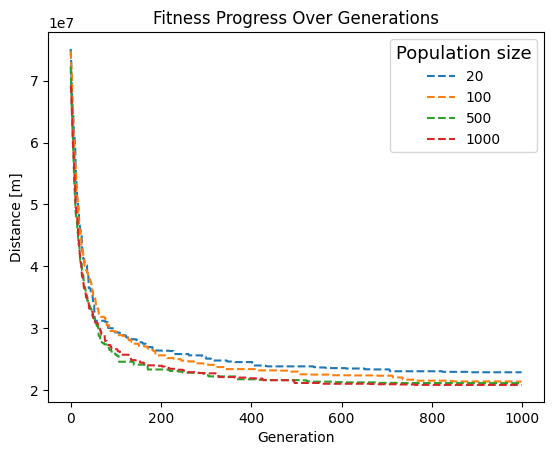

In [52]:
# Plot the fitness values
for pop_size_i in results.keys():
    plt.plot(range(len(results[pop_size_i])), results[pop_size_i], linestyle='dashed')


plt.title('Fitness Progress Over Generations')
plt.xlabel('Generation')
plt.ylabel('Distance [m]')
plt.legend(title='Population size', title_fontsize = 13, labels=results.keys())
plt.grid(False)

# Show or save the plot
plt.savefig('fitness-over-gen.png')

In [50]:
plt.savefig('fitness-over-gen.png')

<Figure size 640x480 with 0 Axes>

In [27]:
def get_lat_lon_from_address(address):
    gmaps_address_result = maps.geocode(address)
    lat = gmaps_address_result[0]['geometry']['location']['lat']
    lon = gmaps_address_result[0]['geometry']['location']['lng']
    
    return (lat, lon)

In [33]:
best_sol = final_population[0]
best_coord = []
for city in best_sol:
    best_coord.append(get_lat_lon_from_address(city))

best_sol

('Tbilisi, Georgia',
 'Istanbul, Turkey',
 'Bucharest, Romania',
 'Lviv, Ukraine',
 'Krakow, Poland',
 'Krakow, Poland',
 'Warsaw, Poland',
 'Gdansk, Poland',
 'Vilnius, Lithuania',
 'Riga, Latvia',
 'Helsinki, Finland',
 'Tallinn, Estonia',
 'Stockholm, Sweden',
 'Bergen, Norway',
 'Oslo, Norway',
 'Copenhagen, Denmark',
 'Berlin, Germany',
 'Prague, Czech Republic',
 'Salzburg, Austria',
 'Munich, Germany',
 'Vienna, Austria',
 'Bratislava, Slovakia',
 'Budapest, Hungary',
 'Ljubljana, Slovenia',
 'Zagreb, Croatia',
 'Sarajevo, Bosnia and Herzegovina',
 'Belgrade, Serbia',
 'Sofia, Bulgaria',
 'Athens, Greece',
 'Naples, Italy',
 'Rome, Italy',
 'Florence, Italy',
 'Nice, France',
 'Marseille, France',
 'Barcelona, Spain',
 'Valencia, Spain',
 'Malaga, Spain',
 'Seville, Spain',
 'Porto Alegre, Portugal',
 'Madrid, Spain',
 'Lyon, France',
 'Geneva, Switzerland',
 'Zurich, Switzerland',
 'Luxembourg City, Luxembourg',
 'Antwerp, Belgium',
 'Amsterdam, Netherlands',
 'Brussels, Belgiu